## Demo 4: HKR multiclass and fooling

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/deel-ai/deel-lip/blob/master/docs/notebooks/demo4.ipynb)

This notebook will show how to train a lispchitz network in a multiclass setup. The HKR
is extended to multiclass using a one-vs all setup. It will go through the process of
designing and training the network. It will also show how to create robustness
certificates from the output of the network. Finally these certificates will be checked
by attacking the network.

### Installation

First, we install the required libraries. `Foolbox` will allow to perform adversarial
attacks on the trained network.


In [1]:
# pip install deel-lip foolbox -qqq

In [2]:
from deel.lip.layers import (
    SpectralDense,
    SpectralConv2D,
    ScaledL2NormPooling2D,
    FrobeniusDense,
)
from deel.lip.model import Sequential
from deel.lip.activations import GroupSort
from deel.lip.losses import MulticlassHKR, MulticlassKR
from keras.layers import Input, Flatten
from keras.optimizers import Adam
from keras.datasets import fashion_mnist
from keras.utils import to_categorical
import numpy as np

2024-09-06 15:26:29.848446: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-06 15:26:29.859784: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-06 15:26:29.863241: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-06 15:26:29.871798: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-06 15:26:31.151634: W tensorflow/compiler/tf2

For this example, the dataset `fashion_mnist` will be used. In order to keep things
simple, no data augmentation will be performed.


In [3]:
# load data
(x_train, y_train_ord), (x_test, y_test_ord) = fashion_mnist.load_data()
# standardize and reshape the data
x_train = np.expand_dims(x_train, -1) / 255
x_test = np.expand_dims(x_test, -1) / 255
# one hot encode the labels
y_train = to_categorical(y_train_ord)
y_test = to_categorical(y_test_ord)

Let's build the network.

### The architecture

The original one vs all setup would require 10 different networks ( 1 per class ),
however, in practice we use a network with a common body and 10 1-lipschitz heads.
Experiments have shown that this setup don't affect the network performance. In order to
ease the creation of such network, `FrobeniusDense` layer has a parameter for this:
whenr `disjoint_neurons=True` it act as the stacking of 10 single neurons head. Note
that, altough each head is a 1-lipschitz function the overall network is not 1-lipschitz
(Concatenation is not 1-lipschitz). We will see later how this affects the certficate
creation.

### The loss

The multiclass loss can be found in `HKR_multiclass_loss`. The loss has two params:
`alpha` and `min_margin`. Decreasing `alpha` and increasing `min_margin` improve
robustness (at the cost of accuracy). note also in the case of lipschitz networks, more
robustness require more parameters. For more information see
[our paper](https://arxiv.org/abs/2006.06520).

In this setup choosing `alpha=100`, `min_margin=.25` provide a good robustness without
hurting the accuracy too much.

Finally the `KR_multiclass_loss()` indicate the robustness of the network ( proxy of the
average certificate )


In [4]:
# Sequential (resp Model) from deel.model has the same properties as any lipschitz model.
# It act only as a container, with features specific to lipschitz
# functions (condensation, vanilla_exportation...)
model = Sequential(
    [
        Input(shape=x_train.shape[1:]),
        # Lipschitz layers preserve the API of their superclass ( here Conv2D )
        # an optional param is available: k_coef_lip which control the lipschitz
        # constant of the layer
        SpectralConv2D(
            filters=16,
            kernel_size=(3, 3),
            activation=GroupSort(2),
            use_bias=True,
            kernel_initializer="orthogonal",
        ),
        # usual pooling layer are implemented (avg, max...), but new layers are also available
        ScaledL2NormPooling2D(pool_size=(2, 2), data_format="channels_last"),
        SpectralConv2D(
            filters=32,
            kernel_size=(3, 3),
            activation=GroupSort(2),
            use_bias=True,
            kernel_initializer="orthogonal",
        ),
        ScaledL2NormPooling2D(pool_size=(2, 2), data_format="channels_last"),
        # our layers are fully interoperable with existing keras layers
        Flatten(),
        SpectralDense(
            64,
            activation=GroupSort(2),
            use_bias=True,
            kernel_initializer="orthogonal",
        ),
        FrobeniusDense(
            y_train.shape[-1],
            activation=None,
            use_bias=False,
            kernel_initializer="orthogonal",
        ),
    ],
    # similary model has a parameter to set the lipschitz constant
    # to set automatically the constant of each layer
    k_coef_lip=1.0,
    name="hkr_model",
)

# HKR (Hinge-Krantorovich-Rubinstein) optimize robustness along with accuracy
model.compile(
    # decreasing alpha and increasing min_margin improve robustness (at the cost of accuracy)
    # note also in the case of lipschitz networks, more robustness require more parameters.
    loss=MulticlassHKR(alpha=100, min_margin=0.25),
    optimizer=Adam(1e-4),
    metrics=["accuracy", MulticlassKR()],
)

model.summary()

I0000 00:00:1725629193.239470  871063 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1725629193.259969  871063 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1725629193.260106  871063 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1725629193.260871  871063 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ spectral_conv2d                 │ (None, 28, 28, 16)     │           321 │
│ (SpectralConv2D)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ scaled_l2_norm_pooling2d        │ (None, 14, 14, 16)     │             0 │
│ (ScaledL2NormPooling2D)         │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spectral_conv2d_1               │ (None, 14, 14, 32)     │         9,281 │
│ (SpectralConv2D)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ scaled_l2_norm_pooling2d_1      │ (None, 7, 7, 32)       │             0 │
│ (ScaledL2NormPooling2D)         │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1568)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spectral_dense (SpectralDense)  │ (None, 64)             │       200,833 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ frobenius_dense                 │ (None, 10)             │         1,280 │
│ (FrobeniusDense)                │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 211,715 (827.01 KB)

 Trainable params: 105,856 (413.50 KB)

 Non-trainable params: 105,859 (413.51 KB)

### Notes about constraint enforcement

There are currently 3 way to enforce a constraint in a network:

1. regularization
2. weight reparametrization
3. weight projection

The first one don't provide the required garanties, this is why `deel-lip` focuses on
the later two. Weight reparametrization is done directly in the layers (parameter
`niter_bjorck`) this trick allow to perform arbitrary gradient updates without breaking
the constraint. However this is done in the graph, increasing ressources consumption.
The last method project the weights between each batch, ensuring the constraint at an
more affordable computational cost. It can be done in `deel-lip` using the
`CondenseCallback`. The main problem with this method is a reduced efficiency of each
update.

As a rule of thumb, when reparametrization is used alone, setting `niter_bjorck` to at
least 15 is advised. However when combined with weight projection, this setting can be
lowered greatly.


In [5]:
# fit the model
model.fit(
    x_train,
    y_train,
    batch_size=4096,
    epochs=100,
    validation_data=(x_test, y_test),
    shuffle=True,
    verbose=1,
)

Epoch 1/100


I0000 00:00:1725629195.757170  871150 service.cc:146] XLA service 0x55ee43b7d460 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1725629195.757189  871150 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce RTX 2070 SUPER, Compute Capability 7.5
2024-09-06 15:26:35.802016: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-09-06 15:26:35.991972: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8902


 7/15 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - MulticlassKR: 0.0541 - accuracy: 0.1560 - loss: 20.3139

I0000 00:00:1725629199.904060  871150 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


15/15 ━━━━━━━━━━━━━━━━━━━━ 10s 328ms/step - MulticlassKR: 0.0763 - accuracy: 0.2224 - loss: 18.1235 - val_MulticlassKR: 0.1733 - val_accuracy: 0.4881 - val_loss: 11.0883
Epoch 2/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - MulticlassKR: 0.2081 - accuracy: 0.4988 - loss: 9.7469 - val_MulticlassKR: 0.2769 - val_accuracy: 0.5344 - val_loss: 7.6648
Epoch 3/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - MulticlassKR: 0.2982 - accuracy: 0.5801 - loss: 7.1314 - val_MulticlassKR: 0.3344 - val_accuracy: 0.6024 - val_loss: 6.3906
Epoch 4/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - MulticlassKR: 0.3466 - accuracy: 0.6334 - loss: 6.0837 - val_MulticlassKR: 0.3680 - val_accuracy: 0.6562 - val_loss: 5.7714
Epoch 5/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - MulticlassKR: 0.3781 - accuracy: 0.6822 - loss: 5.5372 - val_MulticlassKR: 0.3964 - val_accuracy: 0.6994 - val_loss: 5.3437
Epoch 6/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - MulticlassKR: 0.4043 - accuracy: 0.7169 - loss: 5.1466 - val_Mul

### Model exportation

Once training is finished, the model can be optimized for inference by using the
`vanilla_export()` method.


In [6]:
# once training is finished you can convert
# SpectralDense layers into Dense layers and SpectralConv2D into Conv2D
# which optimize performance for inference
vanilla_model = model.vanilla_export()

### Certificates generation and adversarial attacks


In [7]:
import keras.ops as K
import foolbox as fb
import matplotlib.pyplot as plt

In [8]:
# we will test it on 10 samples one of each class
nb_adv = 10

hkr_fmodel = fb.TensorFlowModel(vanilla_model, bounds=(0.0, 1.0), device="/GPU:0")

In order to test the robustness of the model, the first correctly classified element of
each class are selected.


In [9]:
# strategy: first
# we select a sample from each class.
images_list = []
labels_list = []
# select only a few element from the test set
selected = np.random.choice(len(y_test_ord), 500)
sub_y_test_ord = y_test_ord[:300]
sub_x_test = x_test[:300]
# drop misclassified elements
misclassified_mask = K.equal(
    K.argmax(vanilla_model.predict(sub_x_test), axis=-1), sub_y_test_ord
)
sub_x_test = sub_x_test[misclassified_mask]
sub_y_test_ord = sub_y_test_ord[misclassified_mask]
# now we will build a list with input image for each element of the matrix
for i in range(10):
    # select the first element of the ith label
    label_mask = sub_y_test_ord == i
    x = sub_x_test[label_mask][0]
    y = sub_y_test_ord[label_mask][0]
    # convert it to tensor for use with foolbox
    images = K.convert_to_tensor(x.astype("float32"), dtype="float32")
    labels = K.convert_to_tensor(y, dtype="int64")
    # repeat the input 10 times, one per misclassification target
    images_list.append(images)
    labels_list.append(labels)
images = K.convert_to_tensor(images_list)
labels = K.convert_to_tensor(labels_list)

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


In order to build a certficate, we take for each sample the top 2 output and apply this
formula: $$ \epsilon \geq \frac{\text{top}\_1 - \text{top}\_2}{2} $$ Where epsilon is
the robustness radius for the considered sample.


In [10]:
values, classes = K.top_k(hkr_fmodel(images), k=2)
certificates = (values[:, 0] - values[:, 1]) / 2
certificates.numpy()

W0000 00:00:1725629243.480682  871063 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1725629243.505069  871063 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1725629243.505555  871063 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1725629243.506069  871063 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1725629243.506551  871063 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1725629243.507034  871063 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1725629243.507521  871063 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1725629243.507994  871063 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1725629243.508471  871063 gp

array([0.14209856, 0.8908168 , 0.21824726, 0.36170343, 0.07103111,
       0.1333401 , 0.06068115, 0.24836099, 0.57530606, 0.10581052],
      dtype=float32)

now we will attack the model to check if the certificates are respected. In this setup
`L2CarliniWagnerAttack` is used but in practice as these kind of networks are gradient
norm preserving, other attacks gives very similar results.


In [11]:
attack = fb.attacks.L2CarliniWagnerAttack(binary_search_steps=6, steps=8000)
imgs, advs, success = attack(hkr_fmodel, images, labels, epsilons=None)
dist_to_adv = np.sqrt(np.sum(np.square(images - advs), axis=(1, 2, 3)))
dist_to_adv

W0000 00:00:1725629244.976329  871063 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1725629244.976921  871063 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1725629244.977516  871063 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1725629244.978075  871063 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1725629244.978634  871063 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1725629244.979190  871063 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1725629244.979778  871063 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1725629244.980353  871063 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1725629244.980934  871063 gp

array([1.0559031 , 3.8602312 , 1.4908539 , 1.4382323 , 0.47069952,
       0.75099194, 0.42759493, 1.0656103 , 3.062126  , 0.6121775 ],
      dtype=float32)

As we can see the certificate are respected.


In [12]:
np.testing.assert_array_less(certificates, dist_to_adv)

Finally we can take a visual look at the obtained examples. We first start with utility
functions for display.


In [13]:
class_mapping = {
    0: "T-shirt/top",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle boot",
}

In [14]:
def adversarial_viz(model, images, advs, class_mapping):
    """
    This functions shows for each sample:
    - the original image
    - the adversarial image
    - the difference map
    - the certificate and the observed distance to adversarial
    """
    scale = 1.5
    kwargs = {}
    nb_imgs = images.shape[0]
    # compute certificates
    values, classes = K.top_k(model(images), k=2)
    certificates = (values[:, 0] - values[:, 1]) / 2
    # compute difference distance to adversarial
    dist_to_adv = np.sqrt(np.sum(np.square(images - advs), axis=(1, 2, 3)))
    # find classes labels for imgs and advs
    orig_classes = [class_mapping[i] for i in K.argmax(model(images), axis=-1).numpy()]
    advs_classes = [class_mapping[i] for i in K.argmax(model(advs), axis=-1).numpy()]
    # compute differences maps
    if images.shape[-1] != 3:
        diff_pos = np.clip(advs - images, 0, 1.0)
        diff_neg = np.clip(images - advs, 0, 1.0)
        diff_map = np.concatenate(
            [diff_neg, diff_pos, np.zeros_like(diff_neg)], axis=-1
        )
    else:
        diff_map = np.abs(advs - images)
    # expands image to be displayed
    if images.shape[-1] != 3:
        images = np.repeat(images, 3, -1)
    if advs.shape[-1] != 3:
        advs = np.repeat(advs, 3, -1)
    # create plot
    figsize = (3 * scale, nb_imgs * scale)
    fig, axes = plt.subplots(
        ncols=3,
        nrows=nb_imgs,
        figsize=figsize,
        squeeze=False,
        constrained_layout=True,
        **kwargs,
    )
    for i in range(nb_imgs):
        ax = axes[i][0]
        ax.set_title(orig_classes[i])
        ax.set_xticks([])
        ax.set_yticks([])
        ax.axis("off")
        ax.imshow(images[i])
        ax = axes[i][1]
        ax.set_title(advs_classes[i])
        ax.set_xticks([])
        ax.set_yticks([])
        ax.axis("off")
        ax.imshow(advs[i])
        ax = axes[i][2]
        ax.set_title(f"certif: {certificates[i]:.2f}, obs: {dist_to_adv[i]:.2f}")
        ax.set_xticks([])
        ax.set_yticks([])
        ax.axis("off")
        ax.imshow(diff_map[i] / diff_map[i].max())

When looking at the adversarial examples we can see that the network has interesting
properties:

#### Predictability

by looking at the certificates, we can predict if the adversarial example will be close
of not

#### Disparity among classes

As we can see, the attacks are very efficent on similar classes (eg. T-shirt/top, and
Shirt ). This denote that all classes are not made equal regarding robustness.

#### Explainability

The network is more explainable: attacks can be used as counterfactuals. We can tell
that removing the inscription on a T-shirt turns it into a shirt makes sense. Non-robust
examples reveal that the network relies on textures rather on shapes to make its
decision.


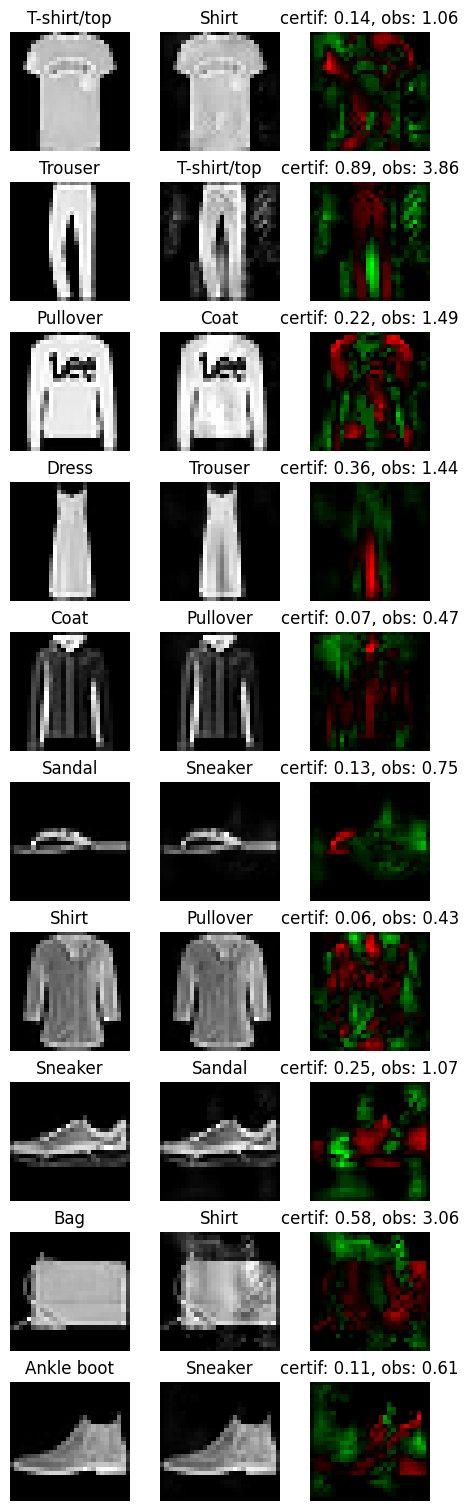

In [15]:
adversarial_viz(hkr_fmodel, images, advs, class_mapping)